## Example: FFT Analysis of Hot Wire data via Python

Murat's Data used. 

100 datasets, each has of 131072 reasilation. 
Mean velocity is 6.842 m/s.



In [2]:
import numpy as np
#import pandas as pd
from scipy.fftpack import fft, ifft,fftshift,fftfreq

data = np.loadtxt('murats_velocity_data.out')  #too slow, http://akuederle.com/stop-using-numpy-loadtxt/
#data = pd.read_csv('../../lfs/murats_velocity_data.out') #will not work that with bare version
print("Data loaded on Ipython environment, and it's shape is", data.shape)

mean_data = np.mean(data)
print("Mean velocity is", mean_data)

fluc_data= data - mean_data

Data loaded on Ipython environment, and it's shape is (131072, 100)
Mean velocity is 6.84244558364


### Function to calculate spectrum

Often magnitude of FT or FFT is not important, **for us it is**!! 
So normalization is important, it is not just the shape.

There are 3 steps to follow;
 1. Take the FFT of the signal 
 2. Calculate spectrum
 3. Normalization
 
**Without satifying all these 3 it is not possible to get correct transform. **

It is always possible to `check` that if your transform is correct or not. To do so,
 1. Check the integral of the are under the estimation of S(f), that should be equalt to var(signal)
 2. IFFT of spectrum should give the correlation, and correlation can be calculated with brute force to compare
 3. In case having both time and space resolved data, spectrums of these to can be compared, of course within the limits of Taylor Hypothesis. Moreover, energy levels should reasonably match, it is a good way to double check correctness of wavenumber/wavelenght conservations. 

In [3]:
# Calculates the spectrum of a given signal with fft
def calc_spectrum(mysignal, size, fs, typeWindow):
    # Window 
    # Add window or periodization here 
    if typeWindow == 'Hanning':
        mysignal    = mysignal[0:size]*np.hanning(size)
        integWindow = np.trapz(np.hanning(size),np.linspace(0,1,size))
    elif typeWindow == 'None':
        mysignal    = mysignal[0:size]*1.0
        integWindow = 1.0
    
    # Take the FFT of the signal, -1 important
    # Remember you have the -1 here if you periodize your signal outside of this routine
    # Multiplying by 2 or not, and having -fs/2:fs/2 frequencies should be compatible
    # following FFT double sided no need to multiply by 2
    # Skip the division by N-1 as well, for the moment, normalization is done at the end
    myfft  = fft(mysignal[0:size-1]) #*2.0 #/float(size-1)
    
    # Calculate spectrum
    # (real**2.0+imag**2.0) is kind of variance
    # if you take sqrt() that makes it kind of standart deviation, same unit as velocity, 
    # nice for Fluid Mechanics applications
    # But let's keep (standart deviation)**2.0, so no need take sqrt() 
    myspec = (myfft.real[0:(size-1)/2]**2.0+myfft.imag[0:(size-1)/2]**2.0) #**0.5
    # OR :: Common way, attention it is missing the sqrt() as well, good
    #myspec = myfft[0:(size)/2]*np.conj(myfft)[0:(size)/2]
    
    # Normalization
    # EXAMPLE :: if the data collected with 30kHz, and you want to have first 256 points, at every 2 points
    # First 256 points that gives the new size
    # New fs 30kHz/2 = 15kHz
    myspec = myspec/(float(size-1)*fs)/(integWindow)
    
    return myspec

In [4]:
N=256              #Choose record length, maximum is 131072 
#N=2000


fs=30000                                                 # Define fs
freq_3 = fftfreq(N, d=1./fs)[0:(N/2)-1]                  # Create frequencies, needed to plot, pick the half of freq.  
spec_3 = calc_spectrum(fluc_data[:   ,0], N, fs, 'None')         # Call function 

fs=15000                                                 # Define fs
freq_4 = fftfreq(int(N/2), d=1./fs)[0:int((N/2)/2)-1]              # Create frequencies, needed to plot, pick the half of freq.
spec_4 = calc_spectrum(fluc_data[0::2,0], N/2, fs,'None')       # Call function

# Loop over the packages (note: this is unefficient) 
for i in range(1,100):
    fs=30000
    spec_3 += calc_spectrum(fluc_data[:   ,i], N, fs,'None')
    fs=15000
    spec_4 += calc_spectrum(fluc_data[0::2,i], N/2, fs,'None')

        
# Do not forget the averaging packages   
spec_3 = spec_3/100.
spec_4 = spec_4/100.

/home/solak/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/solak/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/solak/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/solak/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
#N=256              #Choose record length, maximum is 131072 
N=13072

fs=30000                                                 # Define fs
freq_1 = fftfreq(N, d=1./fs)[0:(N/2)-1]                  # Create frequencies, needed to plot, pick the half of freq.  
spec_1 = calc_spectrum(fluc_data[:   ,0], N, fs, 'None')         # Call function 


# Loop over the packages (note: this is unefficient) 
for i in range(1,100):
    fs=30000
    spec_1 += calc_spectrum(fluc_data[:   ,i], N, fs,'None')


        
# Do not forget the averaging packages   
spec_1 = spec_1/100.


/home/solak/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/solak/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


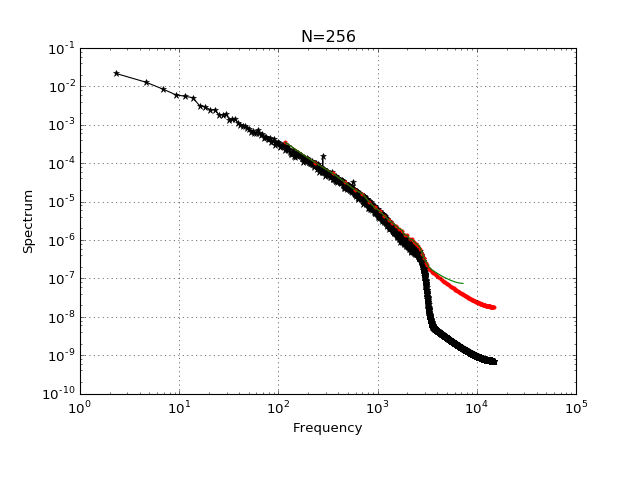

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

#Put data into the plot
ax.loglog(freq_1,spec_1, "k*-")
ax.loglog(freq_3,spec_3, "r.-")
ax.loglog(freq_4,spec_4, "g-")
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


plt.grid()
plt.title("N=256")
plt.xlabel("Frequency")
plt.ylabel("Spectrum")
plt.show()

<IPython.core.display.Javascript object>


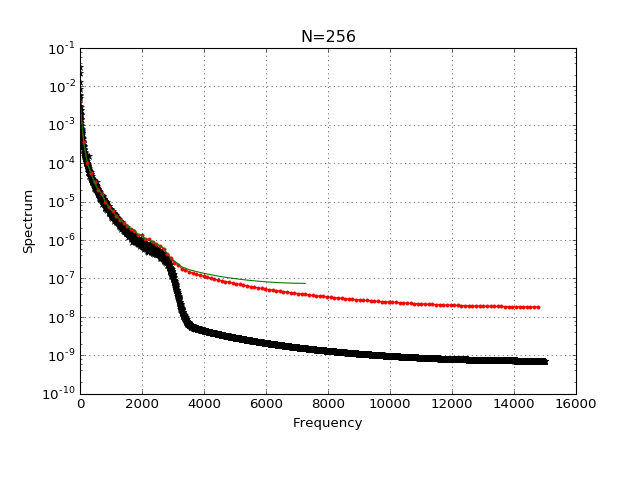

<IPython.core.display.Javascript object>


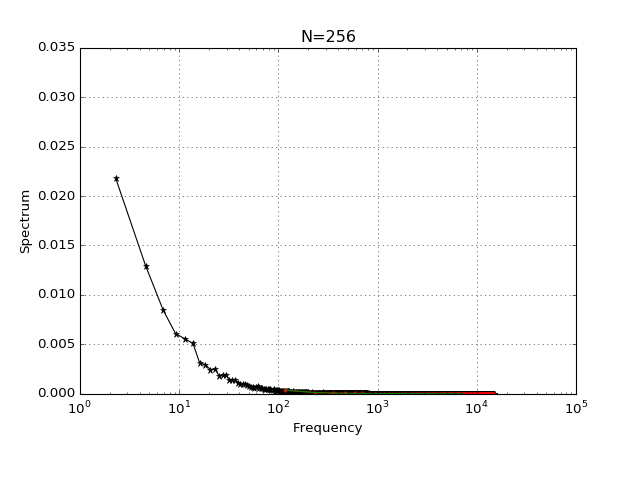

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

#Put data into the plot
ax.semilogy(freq_1,spec_1, "k*-")
ax.semilogy(freq_3,spec_3, "r.-")
ax.semilogy(freq_4,spec_4, "g-")
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


plt.grid()
plt.title("N=256")
plt.xlabel("Frequency")
plt.ylabel("Spectrum")
plt.show()


fig = plt.figure()
ax = plt.subplot(111)

#Put data into the plot
ax.semilogx(freq_1,spec_1, "k*-")
ax.semilogx(freq_3,spec_3, "r.-")
ax.semilogx(freq_4,spec_4, "g-")
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


plt.grid()
plt.title("N=256")
plt.xlabel("Frequency")
plt.ylabel("Spectrum")
plt.show()

In [7]:
'''
Let's check the integral of the are under the estimation of S(f)
'''

# The way calculated it to spectrum is similar to the what is given in Bill's books
# So we need multiply integral by 2. (we took the half of S(f) only)
I1 = np.trapz(spec_1,freq_1)*2.0
I3 = np.trapz(spec_3,freq_3)*2.0
I4 = np.trapz(spec_4,freq_4)*2.0
print('integral of S(f) 1', I1)
print('integral of S(f) 3', I3)
print('integral of S(f) 4', I4)
print('variance of u', np.var(fluc_data))

integral of S(f) 1 0.604697071356
integral of S(f) 3 0.617515167469
integral of S(f) 4 0.615620322208
variance of u 0.593587975241


### Try yourself

- Do test with different windows, any satisfactory result?
- Normalization issues are solved, try to add into this document correlation calculations as well, and then compare with IFFT(S(f)) with brute force correlation results.